In [1]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
raw_dataset = pd.read_csv('/content/churn.csv')
raw_dataset.head()

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,50-100,East South Central,8.0,1.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,50-100,East North Central,7.0,0.0


In [7]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll',
              'product_accounting', 'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [8]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


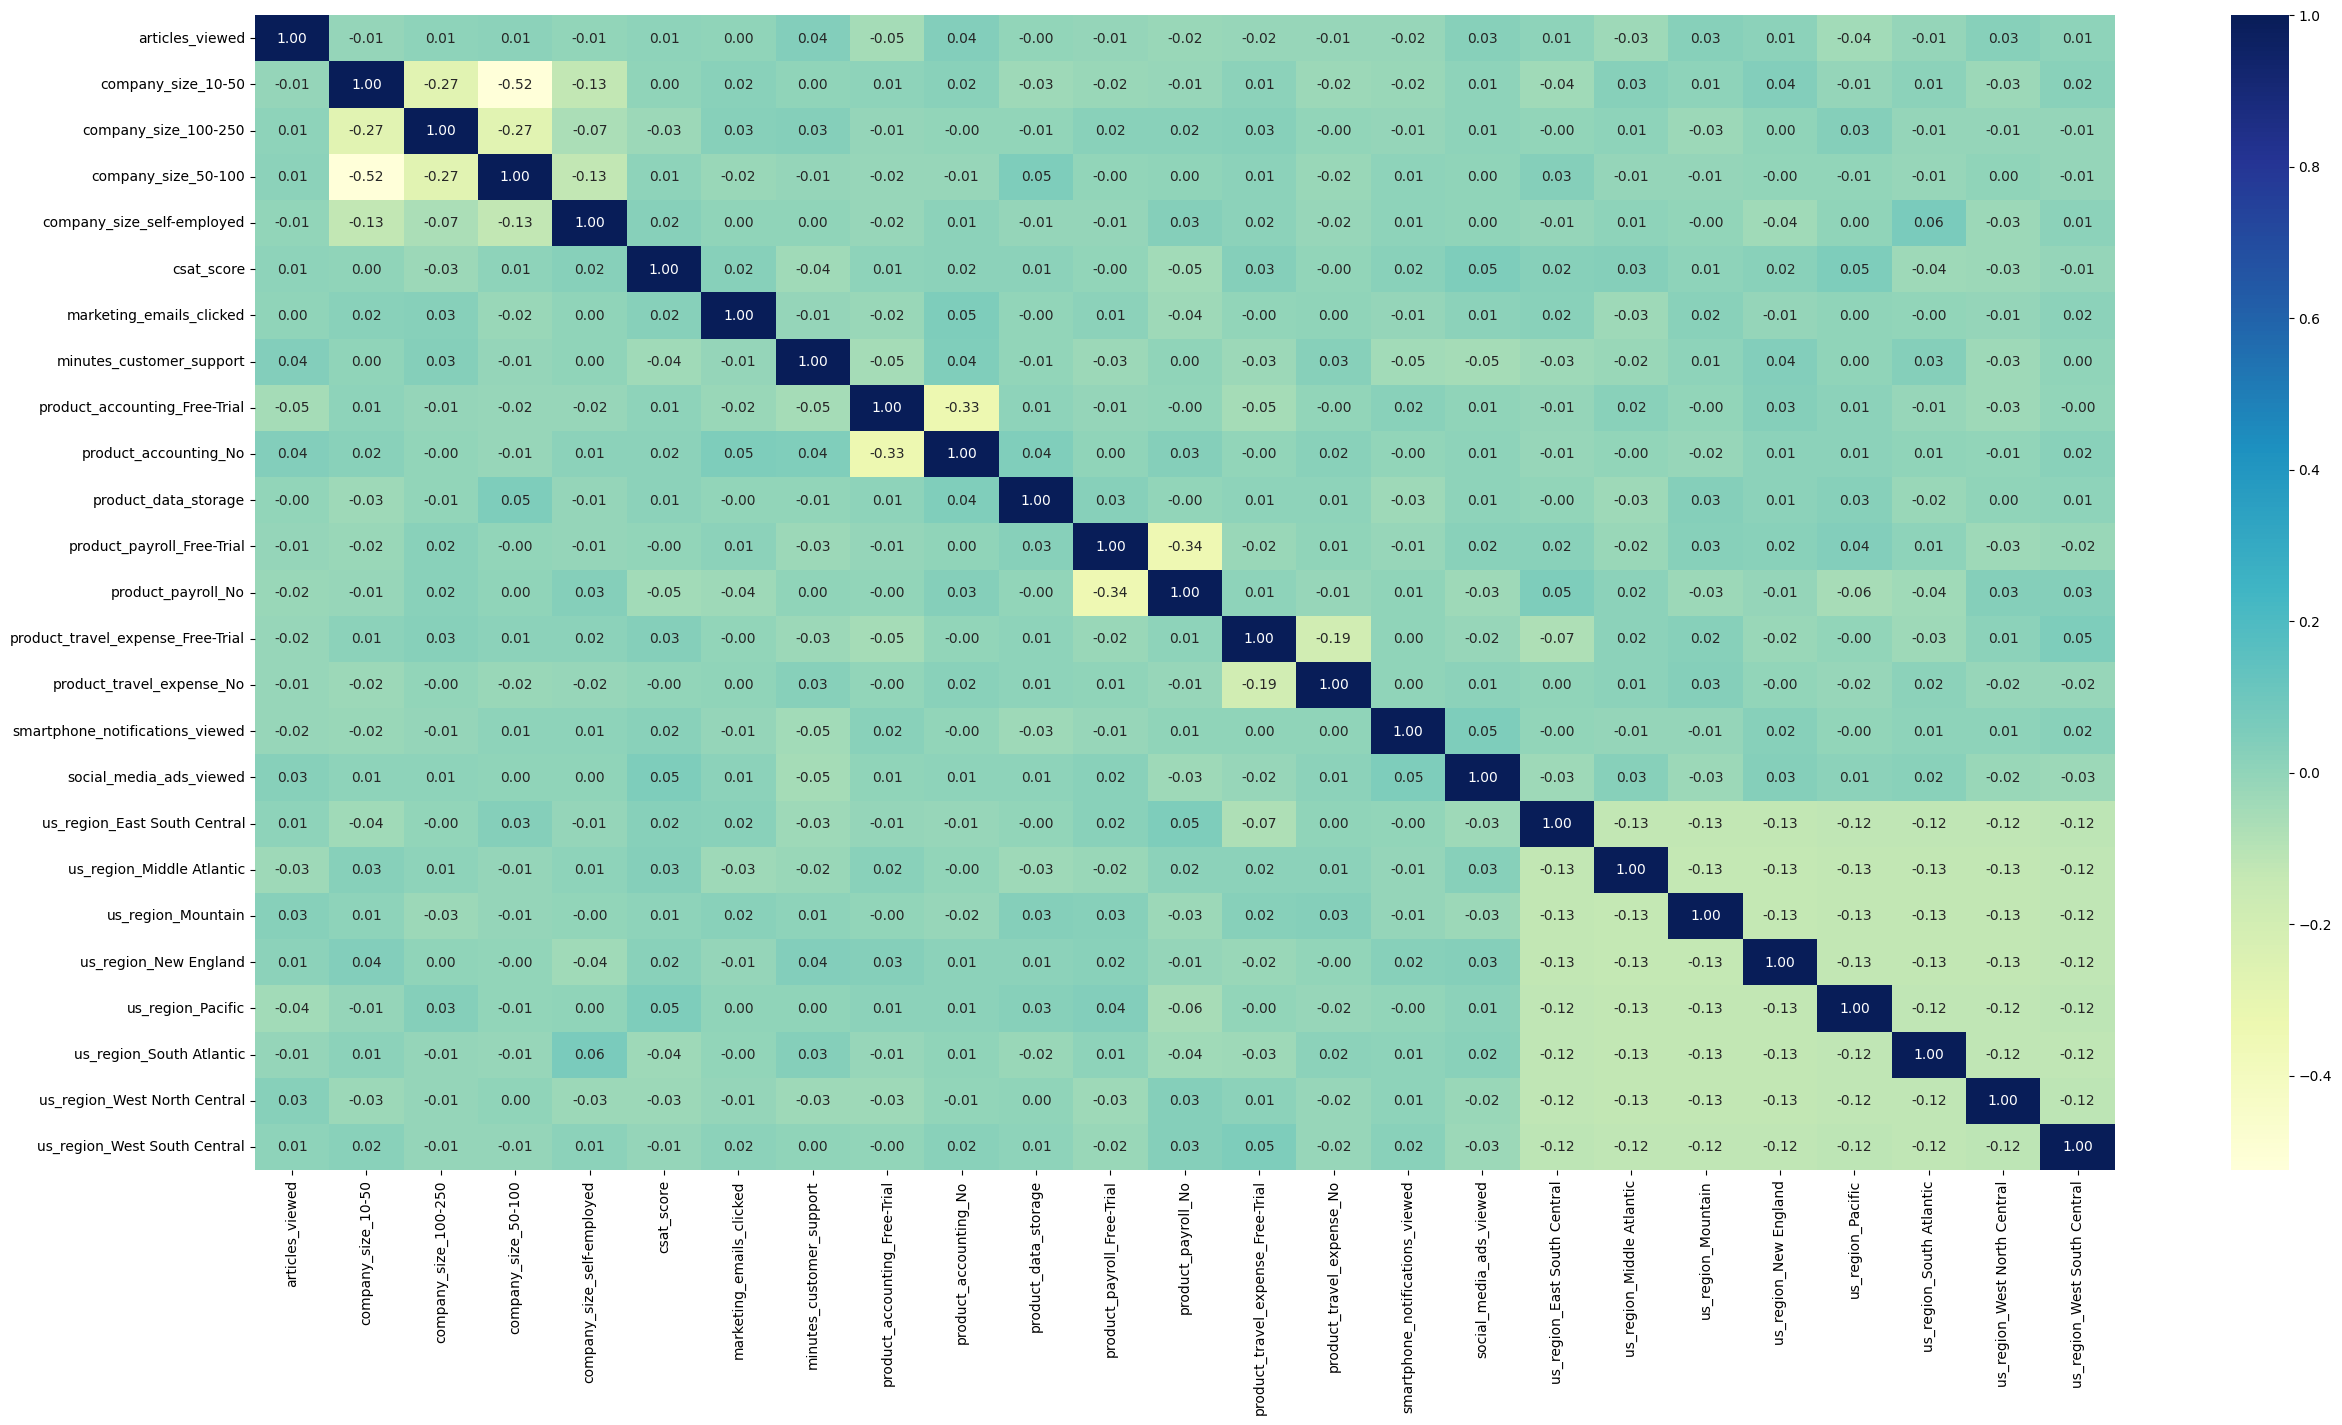

In [9]:
# prompt: create a correlation matrix with these properties;
# correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)

def correlation_matrix(df, figure_size=(10,8), text_fontsize=12):
  '''
  Plots correlation matrix
  args:
    df: pandas dataframe
    figure_size: tuple, matplotlib figure size
    text_fontsize: int, fontsize for correlation values
  '''
  corr_matrix = df.corr()
  fig, ax = plt.subplots(figsize=figure_size)
  sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="YlGnBu",
              annot_kws={"fontsize":text_fontsize})
  plt.show()
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)


In [10]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda))(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=self.loss_function)
        return model

    # def loss_function(self, y_true, y_pred):
    #     Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
    #     Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

    #     phi_uncens = tf.reduce_prod(tf.pow(tf.linalg.matmul(y_pred, Triangle), y_true), axis=1)

    #     reduc_phi_uncens = tf.reduce_sum(phi_uncens, axis=1)

    #     z_uncens = tf.reduce_prod(tf.pow(tf.linalg.matmul(y_pred, Triangle), 1. - y_true), axis=1)
    #     reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

    #     loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
    #     return loss
    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        # Calculate phi_uncens without reducing dimensions
        phi_uncens = tf.pow(tf.linalg.matmul(y_pred, Triangle), y_true)

        # Sum over all elements of phi_uncens
        loss_uncens = -tf.reduce_sum(tf.math.log(phi_uncens))

        # Similarly for z_uncens, calculate without reducing dimensions
        z_uncens = tf.pow(tf.linalg.matmul(y_pred, Triangle), 1. - y_true)
        loss_cens = tf.reduce_sum(tf.math.log(z_uncens))

        loss = loss_uncens + loss_cens
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()




In [ ]:
# Data preparation code remains the same
# Example usage
structure = [{'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(X_train, T_train, E_train, epochs=1000, batch_size=32, verbose=True, validation_split=0.2)




Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3892.2573 - val_loss: 3456.9634
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3661.5686 - val_loss: 3454.5576
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3957.6118 - val_loss: 3452.1150
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4058.1018 - val_loss: 3449.7065
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3852.5298 - val_loss: 3447.3008
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4066.6409 - val_loss: 3444.8977
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4118.7476 - val_loss: 3442.4321
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3650.6931 - val_loss: 3440.0437
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3821.5359 - val_loss: 3437.6055
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3933.6199 - val_loss: 3435.1721
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3881.8149 - 